<a href="https://colab.research.google.com/github/Shravanya178/MLDL_EXPS/blob/main/MLDL_EXP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv("/content/CEEW - IRES Data.csv")

df.shape


Saving CEEW - IRES Data.csv to CEEW - IRES Data (2).csv


/tmp/ipython-input-2454589002.py:5: DtypeWarning: Columns (6,15,22,46,84,98,163,172,179,269,279,330,358,384,418,441,458,474,497) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/CEEW - IRES Data.csv")


(14851, 517)

In [6]:
predictor_cols = [
    "state_abbv",
    "q201_resp_gender",
    "q202_resp_age",
    "q208_priminc_earner_edu",
    "q213_no_members",
    "q216_house_pucca_kachha",
    "q220_own_house_yn",
]

predictor_cols = [c for c in predictor_cols if c in df.columns]
predictor_cols


['state_abbv',
 'q201_resp_gender',
 'q202_resp_age',
 'q208_priminc_earner_edu',
 'q213_no_members',
 'q216_house_pucca_kachha',
 'q220_own_house_yn']

In [7]:
target = "avg_monthly_bill"

data = df[predictor_cols + [target]].dropna().copy()

X = data[predictor_cols]
y = data[target]

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


In [10]:
mlr = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

mlr.fit(X_train, y_train)
pred_mlr = mlr.predict(X_test)

print("MLR RMSE:", np.sqrt(mean_squared_error(y_test, pred_mlr)))
print("MLR R2:", r2_score(y_test, pred_mlr))


MLR RMSE: 601.9304055091847
MLR R2: 0.29194441312993813


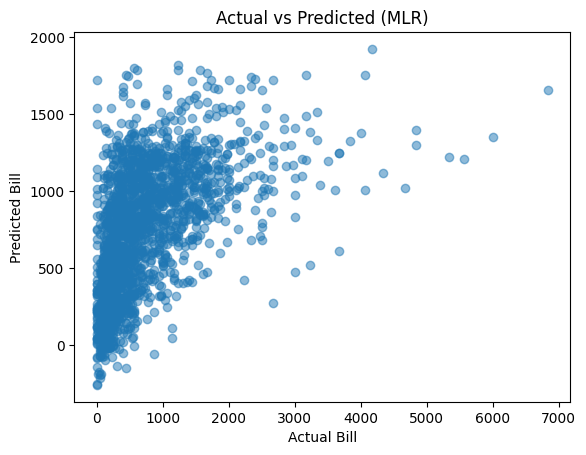

In [11]:
plt.scatter(y_test, pred_mlr, alpha=0.5)
plt.xlabel("Actual Bill")
plt.ylabel("Predicted Bill")
plt.title("Actual vs Predicted (MLR)")
plt.show()


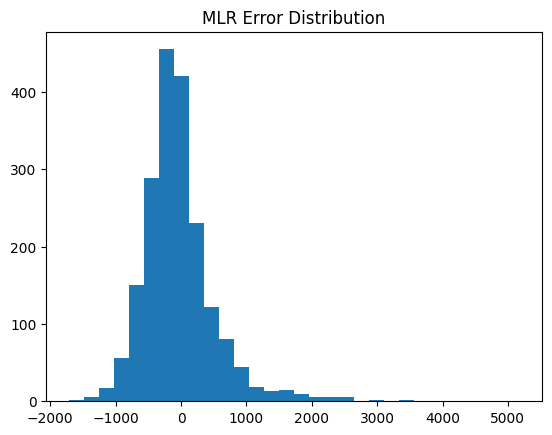

In [12]:
errors = y_test - pred_mlr
plt.hist(errors, bins=30)
plt.title("MLR Error Distribution")
plt.show()


In [13]:
ridge = Pipeline([
    ("prep", preprocess),
    ("model", Ridge())
])

param_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}

grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring="r2")
grid_ridge.fit(X_train, y_train)

best_ridge = grid_ridge.best_estimator_
pred_ridge = best_ridge.predict(X_test)

print("Best alpha:", grid_ridge.best_params_)
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, pred_ridge)))
print("Ridge R2:", r2_score(y_test, pred_ridge))


Best alpha: {'model__alpha': 1}
Ridge RMSE: 601.8757014494711
Ridge R2: 0.2920731049344363


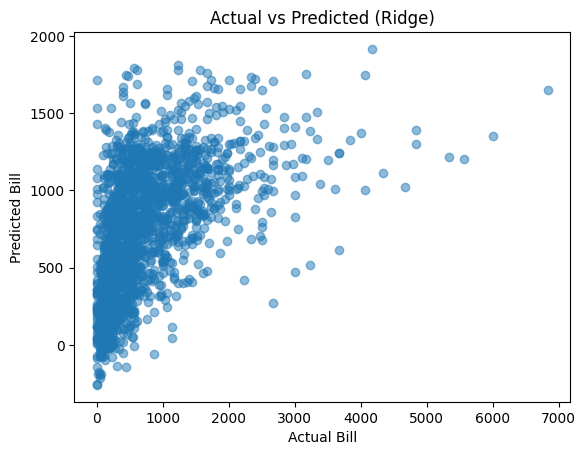

In [14]:
plt.scatter(y_test, pred_ridge, alpha=0.5)
plt.xlabel("Actual Bill")
plt.ylabel("Predicted Bill")
plt.title("Actual vs Predicted (Ridge)")
plt.show()


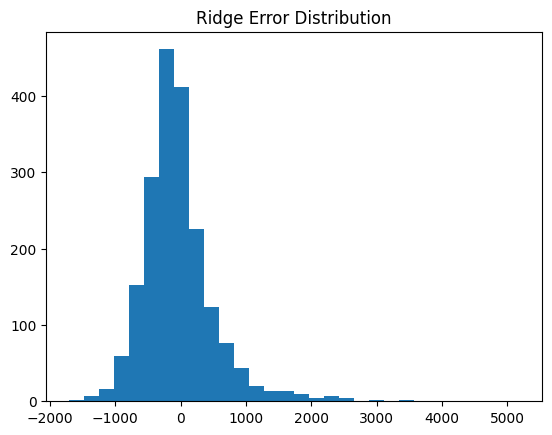

In [15]:
errors = y_test - pred_ridge
plt.hist(errors, bins=30)
plt.title("Ridge Error Distribution")
plt.show()


In [16]:
lasso = Pipeline([
    ("prep", preprocess),
    ("model", Lasso(max_iter=5000))
])

param_grid = {"model__alpha": [0.001, 0.01, 0.1, 1]}

grid_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring="r2")
grid_lasso.fit(X_train, y_train)

best_lasso = grid_lasso.best_estimator_
pred_lasso = best_lasso.predict(X_test)

print("Best alpha:", grid_lasso.best_params_)
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, pred_lasso)))
print("Lasso R2:", r2_score(y_test, pred_lasso))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7606738.524517059, tolerance: 342099.5219695934
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23838825.028111458, tolerance: 351617.06327953504
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha: {'model__alpha': 0.001}
Lasso RMSE: 601.9297183777398
Lasso R2: 0.2919460296855273


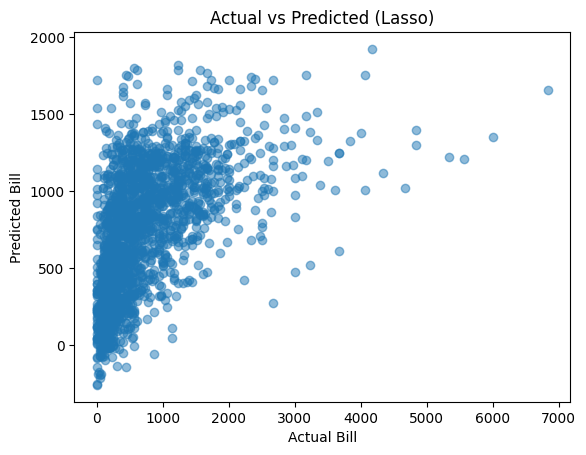

In [17]:
plt.scatter(y_test, pred_lasso, alpha=0.5)
plt.xlabel("Actual Bill")
plt.ylabel("Predicted Bill")
plt.title("Actual vs Predicted (Lasso)")
plt.show()


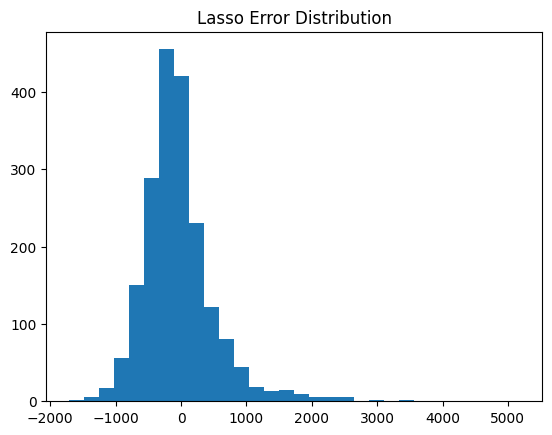

In [18]:
errors = y_test - pred_lasso
plt.hist(errors, bins=30)
plt.title("Lasso Error Distribution")
plt.show()


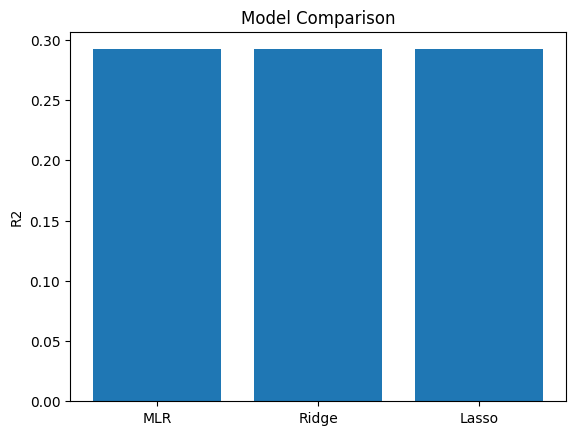

In [19]:
models = ["MLR", "Ridge", "Lasso"]
r2_scores = [
    r2_score(y_test, pred_mlr),
    r2_score(y_test, pred_ridge),
    r2_score(y_test, pred_lasso)
]

plt.bar(models, r2_scores)
plt.ylabel("R2")
plt.title("Model Comparison")
plt.show()


In [20]:
ohe = best_lasso.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_cols)

feature_names = list(num_cols) + list(cat_names)
coefs = best_lasso.named_steps["model"].coef_

importance = pd.Series(coefs, index=feature_names)
importance = importance[importance != 0]

importance.sort_values(key=abs, ascending=False).head(10)


,0
state_abbv_PB,833.412132
state_abbv_HR,816.857663
state_abbv_TN,-551.918907
state_abbv_OR,-447.567934
state_abbv_RJ,441.961776
state_abbv_AP,432.380144
state_abbv_GJ,406.001919
state_abbv_JH,-379.221535
state_abbv_BR,-372.406549
state_abbv_KL,-358.114453
